In [1]:
import os

os.environ["QUIMB_NUM_THREAD_WORKERS"] = "1"
import sys

sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pylab as plt
import matplotlib.font_manager as fm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
plt.rcParams.update({'font.size': 20})

In [5]:
import quimb as qu
import quimb.tensor as qtn

In [6]:
import qiskit
from qiskit import Aer
from qiskit.quantum_info.operators.operator import Operator
from qiskit.circuit import Parameter, ParameterVector
from qiskit import QuantumCircuit, transpile

In [7]:
import seaborn as sns
import scipy
import numpy as np

In [8]:
import pyplnoise
import pickle

In [9]:
from utilities import *
from preprocess import (
    shadow_results_to_data_vec,
    shadow_seqs_to_op_array_rz,
    shadow_seqs_to_op_array,
    pure_measurement,
    clifford_rz_unitaries_vT,
    clifford_measurements_vT,
    clifford_unitaries_vT,
    val_rz_unitaries_vT,
    val_unitaries_vT,
    val_measurements_vT,
    clifford_param_dict,
    validation_param_dict,
)

In [10]:
from optimize import TNOptimizer
from fit_functions import (
    compute_likelihood,
    causality_keys_to_op_arrays,
    compute_probabilities,
)

In [11]:
from process_tensor_networks import (
    create_PT_PEPO_guess,
    expand_initial_guess_,
    create_PEPO_X_decomp,
)

In [12]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.standard_errors import (
    depolarizing_error,
    coherent_unitary_error,
)

In [13]:
error_X = scipy.linalg.expm(-1.0j * np.pi / 32 * X)

In [14]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

In [15]:
NSTEPS = 4
nQ = 1
basis_gates = ["cx", "rz", "sx", "x", "rx", "unitary"]

In [16]:
def create_env_IA(rxx, ryy, rzz):
    U = scipy.linalg.expm(
        -1.0j * 0.5 * (rxx * np.kron(X, X) + ryy * np.kron(Y, Y) + rzz * np.kron(Z, Z))
    )

    U = qiskit.quantum_info.operators.operator.Operator(U, 4, 4)
    return U

In [17]:
def append_PT_gates(circ, env_IA, timesteps, error_param, crosstalk_IA=None):
    """
    Function for the in-place insertion of the parametrised DD sequence into a circuit.

    circ : QuantumCircuit
        Broader circuit into which we're appending our sequence.
        This function should be called at the appropriate gap.

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    q_sys : int
        System (target) qubit from the broader circuit

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure

    """

    param_dict = {
        (q, t): [
            Parameter(f"t{t}_q{q}_x"),
            Parameter(f"t{t}_q{q}_y"),
            Parameter(f"t{t}_q{q}_z"),
        ]
        for q in range(nQ)
        for t in range(NSTEPS + 1)
    }

    # can modify circuit structure here if desired

    for i in range(timesteps):
        for j in range(nQ):
            tmp_gate_params = param_dict[(j, i)]

            circ.rz(tmp_gate_params[2], j + 1)
            circ.sx(j + 1)
            circ.rx(error_param, j + 1)
            circ.rz(tmp_gate_params[0] + np.pi, j + 1)
            circ.sx(j + 1)
            circ.rx(error_param, j + 1)
            circ.rz(tmp_gate_params[1] + 3 * np.pi, j + 1)

            # circ.u(*param_dict[(j,i)], j+1)
        for j in range(nQ):
            circ.append(env_IA, [0, j + 1])
            if crosstalk_IA is not None and j < nQ - 1:
                circ.append(crosstalk_IA, [j + 1, j + 2])

    for j in range(nQ):
        tmp_gate_params = param_dict[(j, NSTEPS)]

        circ.rz(tmp_gate_params[2], j + 1)
        circ.sx(j + 1)
        circ.rx(error_param, j + 1)
        circ.rz(tmp_gate_params[0] + np.pi, j + 1)
        circ.sx(j + 1)
        circ.rx(error_param, j + 1)
        circ.rz(tmp_gate_params[1] + 3 * np.pi, j + 1)

        # circ.u(*param_dict[(j,NSTEPS)], j+1)

    for j in range(nQ):
        circ.measure(j + 1, j)
    return None


def base_PT_circ_template(timesteps, env_IA, error_param, backend, crosstalk_IA=None):
    """
    Create the QuantumCircuit of interest. This template leaves the DD sequence parametrised for later
    process tensor or other validation circuits

    qubit_list : list
        List of physical qubits for passing to the transpilation function

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure
    """

    qreg_size = nQ + 1

    circ = QuantumCircuit(qreg_size, nQ)
    circ.ry(np.pi / 4, 0)
    circ.barrier()
    # Insert fancy circuit here

    append_PT_gates(
        circ, env_IA, timesteps, error_param, crosstalk_IA=crosstalk_IA
    )  # for insertion of DD sequence

    # Insert fancy circuit here

    # return transpile(circ, basis_gates = basis_gates, optimization_level=1)
    return circ

In [18]:
def generate_circ_settings(no_circs, param_dict):
    param_len = len(param_dict)
    seqs = []
    params = []
    for i in range(no_circs):
        circ_seq = list(np.random.randint(0, param_len, (NSTEPS + 1, nQ)))
        params.append(
            np.array([param_dict[N] for param_set in circ_seq for N in param_set])
        )

        seqs.append(np.array(circ_seq).T)
    return seqs, params


def bind_circuit_params(circ_params, env_IA, crosstalk_IA, error_param):
    PT_template_t = base_PT_circ_template(
        NSTEPS, env_IA, error_param, simulator, crosstalk_IA
    )
    PT_template_t.global_phase = 0
    PT_template_t.assign_parameters(circ_params.flatten(), inplace=True)

    return PT_template_t

In [19]:
env_IA = create_env_IA(
    0, 0, 0
)  # No environment interaction to better emphasise the control noise, but works either way
crosstalk_IA = create_env_IA(
    0, 0, 0
)  # Can turn up crosstalk if multiple qubits are desired
error_param = Parameter("err_X")
PT_template_t = base_PT_circ_template(
    NSTEPS, env_IA, error_param, simulator, crosstalk_IA
)
PT_template_t.global_phase = 0

In [20]:
PT_template_t.draw(fold=-1)

┌─────────┐ ░                                                                                             ┌──────────┐                                                                                            ┌──────────┐                                                                                            ┌──────────┐                                                                                            ┌──────────┐                                                                                               
q_0: ┤ Ry(π/4) ├─░─────────────────────────────────────────────────────────────────────────────────────────────┤0         ├────────────────────────────────────────────────────────────────────────────────────────────┤0         ├────────────────────────────────────────────────────────────────────────────────────────────┤0         ├────────────────────────────────────────────────────────────────────────────────────────────┤0         ├───────────────────────────────────────────────────────────────────────────────────────────────
     └─────────┘ ░ ┌─────────────┐┌────┐┌───────────┐┌─────────────────┐┌────┐┌───────────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌───────────┐┌─────────────────┐┌────┐┌───────────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌───────────┐┌─────────────────┐┌────┐┌───────────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌───────────┐┌─────────────────┐┌────┐┌───────────┐┌──────────────────┐│  Unitary │┌─────────────┐┌────┐┌───────────┐┌─────────────────┐┌────┐┌───────────┐┌──────────────────┐┌─┐
q_1: ────────────░─┤ Rz(t0_q0_z) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t0_q0_x + π) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t0_q0_y + 3π) ├┤1         ├┤ Rz(t1_q0_z) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t1_q0_x + π) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t1_q0_y + 3π) ├┤1         ├┤ Rz(t2_q0_z) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t2_q0_x + π) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t2_q0_y + 3π) ├┤1         ├┤ Rz(t3_q0_z) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t3_q0_x + π) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t3_q0_y + 3π) ├┤1         ├┤ Rz(t4_q0_z) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t4_q0_x + π) ├┤ √X ├┤ Rx(err_X) ├┤ Rz(t4_q0_y + 3π) ├┤M├
                 ░ └─────────────┘└────┘└───────────┘└─────────────────┘└────┘└───────────┘└──────────────────┘└──────────┘└─────────────┘└────┘└───────────┘└─────────────────┘└────┘└───────────┘└──────────────────┘└──────────┘└─────────────┘└────┘└───────────┘└─────────────────┘└────┘└───────────┘└──────────────────┘└──────────┘└─────────────┘└────┘└───────────┘└─────────────────┘└────┘└───────────┘└──────────────────┘└──────────┘└─────────────┘└────┘└───────────┘└─────────────────┘└────┘└───────────┘└──────────────────┘└╥┘
c: 1/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                0

In [21]:
num_val_circs = 300
num_char_circs = 3000
num_val_shots = 8192
num_char_shots = 1024


validation_seqs, validation_params = generate_circ_settings(
    num_val_circs, validation_param_dict
)

characterisation_seqs, characterisation_params = generate_circ_settings(
    num_char_circs, clifford_param_dict
)

In [22]:
total_shots = (num_val_circs * num_val_shots) + (num_char_circs * num_char_shots)

Uncomment the following four cells to generate new data, otherwise just load the precomputed stuff

In [ ]:
# sample_frequency = 1000  # Hz
# total_shots

# f_lower = 1e-5
# f_upper = sample_frequency / num_char_circs
# max_angle = np.pi / 4

# pknoise = pyplnoise.PinkNoise(sample_frequency, f_lower, f_upper)
# wp = pknoise.get_series(total_shots)
# wp = max_angle * wp / max(wp)

In [25]:
# t = 0
# val_res_dict = [{"0": 0, "1": 0} for _ in range(num_val_circs)]
# char_res_dict = [{"0": 0, "1": 0} for _ in range(num_char_circs)]

In [26]:
# for j in range(num_char_shots):
#     for i in range(num_char_circs):

#         tmp_circ = PT_template_t.assign_parameters({error_param: wp[t]}, inplace=False)
#         tmp_circ = tmp_circ.assign_parameters(
#             characterisation_params[i].flatten(), inplace=False
#         )

#         tmp_res = list(simulator.run(tmp_circ, shots=1).result().get_counts().keys())[0]
#         char_res_dict[i][tmp_res] += 1
#         t += 1

In [27]:
# for j in range(num_val_shots):
#     for i in range(num_val_circs):

#         tmp_circ = PT_template_t.assign_parameters({error_param: wp[t]}, inplace=False)
#         tmp_circ = tmp_circ.assign_parameters(
#             validation_params[i].flatten(), inplace=False
#         )

#         tmp_res = list(simulator.run(tmp_circ, shots=1).result().get_counts().keys())[0]
#         val_res_dict[i][tmp_res] += 1
#         t += 1

In [23]:
val_res_dict = pickle.load(open("synthetic_pink_noise_val_data.pickle", "rb"))
char_res_dict = pickle.load(open("synthetic_pink_noise_char_data.pickle", "rb"))
validation_seqs = pickle.load(open("synthetic_pink_noise_val_seqs.pickle", "rb"))
characterisation_seqs = pickle.load(open("synthetic_pink_noise_char_seqs.pickle", "rb"))

In [24]:
val_dict = {"res": val_res_dict, "seqs": validation_seqs}


val_shadow_sequences = val_dict["seqs"]
val_data, val_keys = shadow_results_to_data_vec(
    val_dict["res"], shots=num_val_shots, nQ=nQ
)

In [25]:
training_data_flat, training_keys = shadow_results_to_data_vec(
    char_res_dict, num_char_shots, nQ
)

In [26]:
new_char_sequences = []
for seq in characterisation_seqs:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_char_sequences.append(tmp)

In [27]:
new_val_sequences = []
for seq in validation_seqs:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_val_sequences.append(tmp)

In [28]:
training_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_char_sequences, training_keys, pure_measurement, clifford_rz_unitaries_vT
)

In [29]:
val_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_val_sequences, val_keys, pure_measurement, val_rz_unitaries_vT
)

In [30]:
training_sequences_v = shadow_seqs_to_op_array(
    new_char_sequences, training_keys, clifford_measurements_vT, clifford_unitaries_vT
)

In [31]:
val_sequences_v = shadow_seqs_to_op_array(
    new_val_sequences, val_keys, val_measurements_vT, val_unitaries_vT
)

In [32]:
nS = NSTEPS

no_epochs = 600
batch_size = 1000
K_lists = [[1] + [1 for j in range(nS - 1)] + [1] for i in range(nQ)]
vertical_bonds = [[1] + [1 for i in range(nQ - 3)] + [1] for j in range(nS)] + [
    [1 for i in range(nQ - 1)]
]
horizontal_bonds = [1 for i in range(nS)]
initial_guess = create_PT_PEPO_guess(nS, nQ, horizontal_bonds, vertical_bonds, K_lists)
initial_guess = qu.tensor.tensor_2d.TensorNetwork2DFlat.from_TN(
    initial_guess,
    site_tag_id="q{}_I{}",
    Ly=nS + 1,
    Lx=nQ,
    row_tag_id="ROWq{}",
    col_tag_id="COL{}",
)

real_K_lists = [[2] + [1 for j in range(nS - 1)] + [2] for i in range(nQ)]
real_vertical_bonds = [[2 for i in range(nQ - 1)]] + [
    [2] + [2 for i in range(nQ - 3)] + [2] for j in range(nS)
]
real_horizontal_bonds = [[2 for i in range(nS + 1)] for i in range(nQ)]
expand_initial_guess_(
    initial_guess,
    real_K_lists,
    real_horizontal_bonds,
    real_vertical_bonds,
    rand_strength=0.05,
    squeeze=False,
)
initial_guess.squeeze_()
Lx = initial_guess.Lx
Ly = initial_guess.Ly

In [33]:
X_guess = create_PEPO_X_decomp(nS, nQ)

In [34]:
instructions = {
    "normal": {
        "initial_tn": initial_guess,
        "training_seqs": training_sequences_v,
        "val_seqs": val_sequences_v,
        "likelihood_const": False,
    },
    "X_decomp": {
        "initial_tn": initial_guess & X_guess,
        "training_seqs": training_sequences_v_rz,
        "val_seqs": val_sequences_v_rz,
        "likelihood_const": True,
    },
}

In [35]:
mode = "X_decomp"

In [36]:
for i in range(6000):
    if training_data_flat[i] < 1e-6:
        training_data_flat[i] = 1e-7

data_entropy = (
    -(1 / len(training_data_flat))
    * np.array(training_data_flat)
    @ np.log(np.array(training_data_flat))
)
v_data_entropy = -(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(val_data))
print(data_entropy)
print(v_data_entropy)

0.2595775936524876
0.269528344257649


In [37]:
iterations = int(4 * no_epochs * len(training_data_flat) / batch_size)
print(iterations)

14400


In [38]:
Xoptmzr = TNOptimizer(
    instructions[mode][
        "initial_tn"
    ],  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [39]:
X_pepo_opt = Xoptmzr.optimize(iterations)  # regular

+0.2676606 [best loss: +0.2486080] [best val: +0.2723469; (5742)]:  40%|███▉      | 5750/14400 [06:58<09:49, 14.67it/s]

In [ ]:
Xoptmzr.val_best - v_data_entropy

0.0008594813629482778

In [ ]:
best_val_mpo_X = Xoptmzr.best_val_mpo

In [ ]:
v_predictions = compute_probabilities(
    best_val_mpo_X,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions = sum(val_data) * v_predictions / sum(v_predictions)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions)))

0.2903574962848933


In [ ]:
v_predictions_norm = []
for i in range((2**nQ) * 300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        v_predictions_norm.append(v)
v_predictions_norm = np.array(v_predictions_norm)

In [ ]:
from scipy.stats import describe

In [ ]:
describe(np.abs(np.array(val_data) - v_predictions_norm))

DescribeResult(nobs=600, minmax=(1.8775463104248047e-05, 0.08517825603485107), mean=0.018884454425424337, variance=0.0002525315311059181, skewness=1.3973070642932472, kurtosis=1.96862665683026)

In [ ]:
v_fidelities = []
for i in range(300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    v_fidelities.append(hellinger_fidelity(tmp_v, actual_v))

In [ ]:
describe(v_fidelities)

DescribeResult(nobs=300, minmax=(0.9888222897367878, 1.0000000804473494), mean=0.9991672026504937, variance=2.032966056892154e-06, skewness=-3.356471996022601, kurtosis=14.327266473653388)

In [ ]:
new_X_guess = create_PEPO_X_decomp(nS, nQ, rand_strength=0.0)

In [ ]:
X_bond = 2

for i in range(2 * (NSTEPS + 1)):
    if i == 0:
        new_X_guess.tensors[i].new_ind(f"left_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"left_bond_{i}", X_bond)

    elif i == 2 * (NSTEPS + 1) - 1:
        new_X_guess.tensors[i].new_ind(f"right_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"right_bond_{i}", X_bond)
    else:
        new_X_guess.tensors[i].new_ind(f"left_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"left_bond_{i}", X_bond)
        new_X_guess.tensors[i].new_ind(f"right_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"right_bond_{i}", X_bond)

In [ ]:
for i in range(2 * (NSTEPS + 1) - 1):
    if i == 0:
        qtn.tensor_core.connect(
            new_X_guess.tensors[i], new_X_guess.tensors[i + 1], 0, 0
        )
    if i > 0:
        qtn.tensor_core.connect(
            new_X_guess.tensors[i], new_X_guess.tensors[i + 1], 1, 0
        )

In [ ]:
rand_strength = 0.025

for i in range(2 * (NSTEPS + 1)):
    tmp_D = new_X_guess.tensors[i].data
    new_X_guess.tensors[i].modify(
        data=tmp_D
        + rand_strength * np.random.rand(*tmp_D.shape)
        + rand_strength * 1.0j * np.random.rand(*tmp_D.shape)
    )

In [ ]:
corr_Xoptmzr = TNOptimizer(
    initial_guess & new_X_guess,  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [ ]:
print(v_data_entropy)

0.28950505229984774


In [ ]:
corr_X_pepo_opt = corr_Xoptmzr.optimize(2 * iterations)

+0.2819399 [best loss: +0.2727031] [best val: +0.2895550; (24743)]: : 28801it [1:54:03,  4.21it/s]                           


In [ ]:
corr_Xoptmzr.val_best - v_data_entropy

4.993107760892235e-05

In [62]:
best_val_mpo_corrX = corr_Xoptmzr.best_val_mpo

In [63]:
corr_v_predictions = compute_probabilities(
    best_val_mpo_corrX,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
corr_v_predictions = sum(val_data) * corr_v_predictions / sum(corr_v_predictions)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(corr_v_predictions)))

0.28955412554702664


In [64]:
corr_v_predictions_norm = []
for i in range((2**nQ) * 300):
    tmp_v = corr_v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        corr_v_predictions_norm.append(v)
corr_v_predictions_norm = np.array(corr_v_predictions_norm)

In [65]:
describe(np.abs(np.array(val_data) - corr_v_predictions_norm))

DescribeResult(nobs=600, minmax=(5.364418029785156e-06, 0.01852351427078247), mean=0.004812236850460371, variance=1.3546955789822327e-05, skewness=0.9396926105398297, kurtosis=0.40360282605678055)

In [66]:
corr_v_fidelities = []
for i in range(300):
    tmp_v = corr_v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    corr_v_fidelities.append(hellinger_fidelity(tmp_v, actual_v))

In [67]:
describe(corr_v_fidelities)

DescribeResult(nobs=300, minmax=(0.9996208577452905, 1.0000000167422782), mean=0.9999541271381515, variance=3.7117172088496303e-09, skewness=-2.1927796347206807, kurtosis=5.822639132923056)

In [68]:
no_batches = Xoptmzr._nBatches
epoch_losses_X = [
    Xoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(Xoptmzr._n / no_batches))
]
epoch_val_losses_X = [
    Xoptmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(Xoptmzr._n / no_batches))
]

In [69]:
epoch_losses_corrX = [
    corr_Xoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(corr_Xoptmzr._n / no_batches))
]
epoch_val_losses_corrX = [
    corr_Xoptmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(corr_Xoptmzr._n / no_batches))
]

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-e

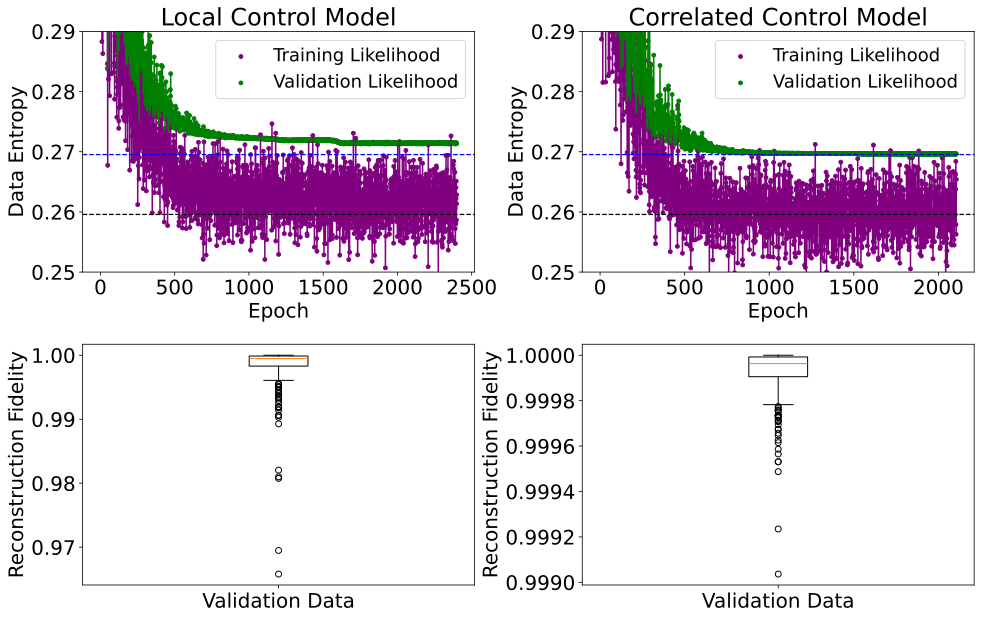

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))


ax[0, 0].plot(epoch_losses_X, color="purple")
ax[0, 0].plot(epoch_val_losses_X, color="green")
ax[0, 0].scatter(
    range(len(epoch_losses_X)),
    epoch_losses_X,
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 0].scatter(
    range(len(epoch_val_losses_X)),
    epoch_val_losses_X,
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 0].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 0].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 0].set_title("Local Control Model", fontsize=24)
ax[0, 0].set_ylabel("Data Entropy")
ax[0, 0].set_ylim(0.25, 0.29)
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].legend(fontsize=18)

xticks = ax[0, 0].get_xticklabels()
yticks = ax[0, 0].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)


ax[0, 1].plot(epoch_losses_corrX, color="purple")
ax[0, 1].plot(epoch_val_losses_corrX, color="green")
ax[0, 1].scatter(
    range(len(epoch_losses_corrX)),
    epoch_losses_corrX,
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 1].scatter(
    range(len(epoch_val_losses_corrX)),
    epoch_val_losses_corrX,
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 1].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 1].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 1].set_title("Correlated Control Model", fontsize=24)
ax[0, 1].set_ylabel("Data Entropy")
ax[0, 1].set_ylim(0.25, 0.29)
ax[0, 1].set_xlabel("Epoch")
ax[0, 1].legend(fontsize=18)

xticks = ax[0, 1].get_xticklabels()
yticks = ax[0, 1].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)

# Bottom left: Box plot for v_fidelities_U
plt.subplot(2, 2, 3)
plt.boxplot(np.array(v_fidelities))
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)


# Bottom right: Box plot for v_fidelities
# plt.subplot(2,2,4, sharey=plt.gca())
plt.subplot(2, 2, 4)
# plt.yscale('log')
plt.boxplot(np.array(corr_v_fidelities))
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

plt.subplots_adjust(hspace=0.3, wspace=0.275)

# plt.savefig('Correlated_Coherent_Error_Benchmark.pdf', bbox_inches = 'tight')
plt.show()